# Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os
from utils import *

import pandas as pd 
import numpy as np 
import seaborn as sns
import statsmodels.api as sm 
import matplotlib.pyplot as plt 

from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.linear_model import Lasso 
from sklearn.metrics import mean_squared_error 

from talib import RSI, BBANDS, MACD, NATR, ATR

# Load Data

## Check Data Input

In [3]:
data = pd.read_parquet('Combined Clean Data Filtered.csv.parquet')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3206758 entries, 2022-01-03 09:57:44 to 2023-03-31 15:49:58
Columns: 377 entries, X1 to Y2
dtypes: float32(377)
memory usage: 4.5 GB


In [5]:
data = data.resample(rule='12H').mean().dropna() 

In [6]:
data.head()

,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
time,,,,,,,,,,,,,,,,,,,,,
2022-01-03 00:00:00,0.068942,0.428335,0.017969,0.020077,0.042287,0.042625,0.065552,-0.008052,-0.013215,0.059516,...,0.038223,0.038590,-0.190782,-0.436655,-0.169957,-0.123018,0.082910,0.029586,-0.807994,-0.305133
2022-01-03 12:00:00,0.473068,0.064733,-0.016727,-0.015065,-0.003647,-0.008741,-0.000208,-0.043048,-0.034050,-0.008055,...,-0.002751,-0.007727,0.004366,-0.157683,-0.117361,-0.073352,-0.030915,0.000329,0.959805,1.194735
2022-01-04 00:00:00,-0.190049,0.501462,0.016742,0.009144,-0.003687,-0.006071,0.049916,-0.015306,0.006405,0.038204,...,-0.002494,-0.003193,0.278834,-0.137937,0.142086,0.536449,0.431356,0.016378,-2.225570,-7.294621
2022-01-04 12:00:00,-0.005852,0.215169,-0.006019,-0.008318,0.004861,0.004961,0.022689,-0.013130,-0.018766,0.016892,...,0.003835,0.003971,0.083652,-0.012055,-0.014927,0.065504,0.120930,0.013042,0.251694,1.047342
2022-01-05 00:00:00,-0.228408,0.040838,0.073119,0.070768,0.037912,0.031629,0.051789,0.118844,0.125025,0.074790,...,0.033979,0.028445,-0.070204,-0.355912,-0.030104,0.004571,-0.001903,0.038807,-0.885290,-0.659349


In [7]:
X = data.drop(columns=['Y1', 'Y2']) 
Y1 = data['Y1'] 
Y2 = data['Y2'] 

In [8]:
def testStationarity(df):
    results = []
    for column in df.columns:
        adf_result = adfuller(df[column].dropna()) # Performing the ADF Test
        test_statistic = adf_result[0] # Extracting Test Statistic 
        p_value = adf_result[1] # Extracting P-Value
        results.append([column, test_statistic, p_value])
    results_df = pd.DataFrame(results, columns=['Column', 'Test statistic', 'P-Value'])
    results_df.set_index('Column', inplace=True)
    return results_df

# Test the stationarity for independent variables 
testStationarity(X).sort_values('P-Value')

,Test statistic,P-Value
Column,,
X237,-24.366257,0.000000
X196,-21.030156,0.000000
X197,-21.013955,0.000000
X145,-19.466608,0.000000
X144,-19.920434,0.000000
...,...,...
X52,-3.853147,0.002408
X79,-3.597403,0.005811
X232,-3.278366,0.015874


Text(0.5, 1.0, 'Scatter Plot for 1 Dimension')

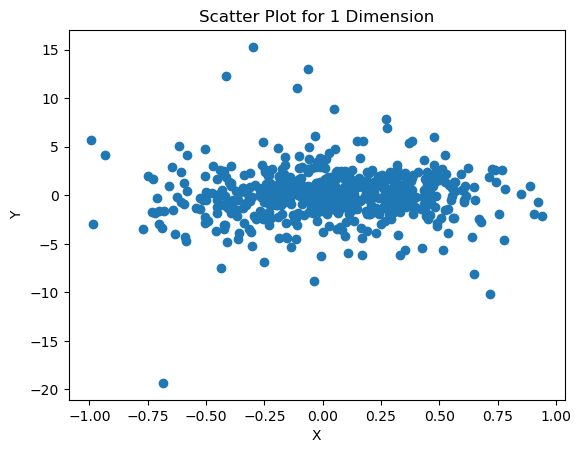

In [9]:
plt.scatter(data['X1'], data['Y1']) 
plt.xlabel('X') 
plt.ylabel('Y') 
plt.title('Scatter Plot for 1 Dimension')

## Train Test Split and Scale

In [10]:
X_train_Y1, X_test_Y1, Y1_train, Y1_test = train_test_split(X, Y1, test_size=0.2, random_state=42)
X_train_Y2, X_test_Y2, Y2_train, Y2_test = train_test_split(X, Y2, test_size=0.2, random_state=42)

In [11]:
scaler = StandardScaler() 
X_train_scaled_Y1 = scaler.fit_transform(X_train_Y1) 
X_train_scaled_Y2 = scaler.fit_transform(X_train_Y2) 

# Feature Selection

## Tuning Y1

### PCA

In [12]:
pca = PCA(n_components=4) 
X_pca1 = pd.DataFrame(pca.fit_transform(X_train_scaled_Y1), index=X_train_Y1.index) 
explained_variance1 = pca.explained_variance_ratio_

In [13]:
explained_variance1

array([0.22842221, 0.16981015, 0.14296457, 0.06324006], dtype=float32)

In [14]:
sum(explained_variance1)

0.6044369861483574

In [15]:
model_pca1 = sm.OLS(Y1_train, X_pca1).fit() 
model_pca1.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     Y1   R-squared (uncentered):                   0.414
Model:                            OLS   Adj. R-squared (uncentered):              0.409
Method:                 Least Squares   F-statistic:                              82.98
Date:                Sun, 21 Jan 2024   Prob (F-statistic):                    2.92e-53
Time:                        13:32:35   Log-Likelihood:                         -1023.9
No. Observations:                 474   AIC:                                      2056.
Df Residuals:                     470   BIC:                                      2072.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1346      0.010    -12.870      0.000      -0.155      -0.114
1             -0.0592      0.012     -4.878      0.000      -0.083      -0.035
2             -0.1209      0.013     -9.147      0.000      -0.147      -0.095
3             -0.1524      0.020     -7.669      0.000      -0.191      -0.113
==============================================================================
Omnibus:                      233.276   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5618.301
Skew:                           1.580   Prob(JB):                         0.00
Kurtosis:                      19.567   Cond. No.                         1.90
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### LASSO

In [16]:
lasso1 = Lasso(alpha=0.7) 

In [17]:
lasso1.fit(X_train_scaled_Y1, Y1_train) 

Lasso(alpha=0.7)

In [18]:
coefficients_Y1 = lasso1.coef_
features_Y1 = X.columns
feature_coefficients_Y1 = pd.DataFrame(list(zip(features_Y1, coefficients_Y1)), columns=['Feature', 'Coefficient']).set_index('Feature')
feature_coefficients_Y1 = feature_coefficients_Y1.replace(0, np.nan).dropna(how='all')

In [19]:
feature_coefficients_Y1 

,Coefficient
Feature,
X129,-0.163393
X202,0.047588
X204,0.314638
X224,0.943346
X245,-0.044056


In [20]:
selected1 = feature_coefficients_Y1.index.to_list() 

In [21]:
X_train_new1 = X_train_Y1[selected1]
X_test_new1 = X_test_Y1[selected1]

In [22]:
model_lasso_in1 = sm.OLS(Y1_train,X_train_new1).fit() 

In [23]:
model_lasso_in1.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     Y1   R-squared (uncentered):                   0.630
Model:                            OLS   Adj. R-squared (uncentered):              0.626
Method:                 Least Squares   F-statistic:                              159.4
Date:                Sun, 21 Jan 2024   Prob (F-statistic):                    9.95e-99
Time:                        13:32:36   Log-Likelihood:                         -915.13
No. Observations:                 474   AIC:                                      1840.
Df Residuals:                     469   BIC:                                      1861.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X129         -63.0003     43.914     -1.435      0.152    -149.292      23.292
X202           0.0245      0.018      1.399      0.162      -0.010       0.059
X204           0.0540      0.029      1.833      0.067      -0.004       0.112
X224           0.3629      0.056      6.528      0.000       0.254       0.472
X245         -23.4289      7.459     -3.141      0.002     -38.086      -8.772
==============================================================================
Omnibus:                      267.746   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4338.477
Skew:                           2.078   Prob(JB):                         0.00
Kurtosis:                      17.227   Cond. No.                     8.50e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
pred1 = model_lasso_in1.predict(X_test_new1)

In [25]:
mse1 = mean_squared_error(Y1_test, pred1)
print("Mean Squared Error:", mse1)

Mean Squared Error: 2.4883504


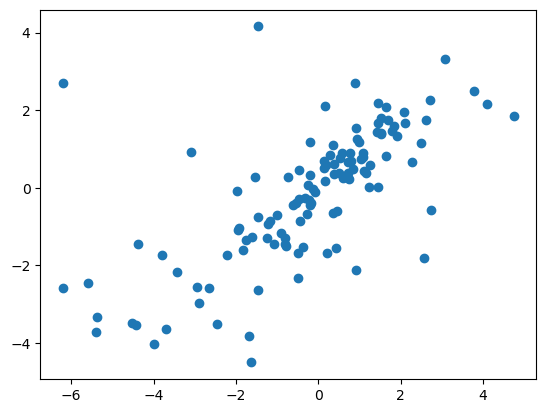

In [26]:
plt.scatter(Y1_test, pred1)

In [27]:
oos_r2_1 = 1 - sum((Y1_test-pred1)**2)/Y1_test.var()
print("Out of Sample R-Sqaured:", oos_r2_1)

Out of Sample R-Sqaured: -64.85734230985501


## Tuning Y2

### PCA

In [28]:
X_pca2 = pd.DataFrame(pca.fit_transform(X_train_scaled_Y2), index=X_train_Y2.index) 
explained_variance2 = pca.explained_variance_ratio_

In [29]:
explained_variance2

array([0.22842221, 0.16981015, 0.14296457, 0.06324006], dtype=float32)

In [30]:
sum(explained_variance2)

0.6044369861483574

In [31]:
model_pca2 = sm.OLS(Y2_train, X_pca2).fit() 
model_pca2.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     Y2   R-squared (uncentered):                   0.414
Model:                            OLS   Adj. R-squared (uncentered):              0.409
Method:                 Least Squares   F-statistic:                              83.13
Date:                Sun, 21 Jan 2024   Prob (F-statistic):                    2.44e-53
Time:                        13:32:36   Log-Likelihood:                         -1130.1
No. Observations:                 474   AIC:                                      2268.
Df Residuals:                     470   BIC:                                      2285.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1823      0.013    -13.935      0.000      -0.208      -0.157
1             -0.0667      0.015     -4.393      0.000      -0.096      -0.037
2             -0.1184      0.017     -7.161      0.000      -0.151      -0.086
3             -0.2047      0.025     -8.233      0.000      -0.254      -0.156
==============================================================================
Omnibus:                      199.292   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3897.363
Skew:                           1.314   Prob(JB):                         0.00
Kurtosis:                      16.800   Cond. No.                         1.90
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### LASSO

In [32]:
lasso2 = Lasso(alpha=0.8) 

In [33]:
lasso2.fit(X_train_scaled_Y2, Y2_train) 

Lasso(alpha=0.8)

In [34]:
coefficients_Y2 = lasso2.coef_
features_Y2 = X.columns
feature_coefficients_Y2 = pd.DataFrame(list(zip(features_Y2, coefficients_Y2)), columns=['Feature', 'Coefficient']).set_index('Feature')
feature_coefficients_Y2 = feature_coefficients_Y2.replace(0, np.nan).dropna(how='all')

In [35]:
feature_coefficients_Y2

,Coefficient
Feature,
X129,-0.010267
X194,1.311064
X202,0.521035
X204,0.075012
X242,-0.031730


In [36]:
selected2 = feature_coefficients_Y2.index.to_list() 

In [37]:
X_train_new2 = X_train_Y2[selected2]
X_test_new2 = X_test_Y2[selected2]

In [38]:
model_lasso_in2 = sm.OLS(Y2_train, X_train_new2).fit() 

In [39]:
model_lasso_in2.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     Y2   R-squared (uncentered):                   0.649
Model:                            OLS   Adj. R-squared (uncentered):              0.646
Method:                 Least Squares   F-statistic:                              173.7
Date:                Sun, 21 Jan 2024   Prob (F-statistic):                   2.70e-104
Time:                        13:32:36   Log-Likelihood:                         -1008.5
No. Observations:                 474   AIC:                                      2027.
Df Residuals:                     469   BIC:                                      2048.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X129         -45.5991     45.884     -0.994      0.321    -135.764      44.565
X194           0.3841      0.051      7.572      0.000       0.284       0.484
X202           0.0385      0.024      1.585      0.114      -0.009       0.086
X204           0.0592      0.030      1.983      0.048       0.001       0.118
X242         -20.8167      6.350     -3.278      0.001     -33.295      -8.338
==============================================================================
Omnibus:                      158.511   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1654.229
Skew:                           1.129   Prob(JB):                         0.00
Kurtosis:                      11.869   Cond. No.                     7.37e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
pred2 = model_lasso_in2.predict(X_test_new2)

In [41]:
mse2 = mean_squared_error(Y2_test, pred2)
print("Mean Squared Error:", mse2)

Mean Squared Error: 4.6676726


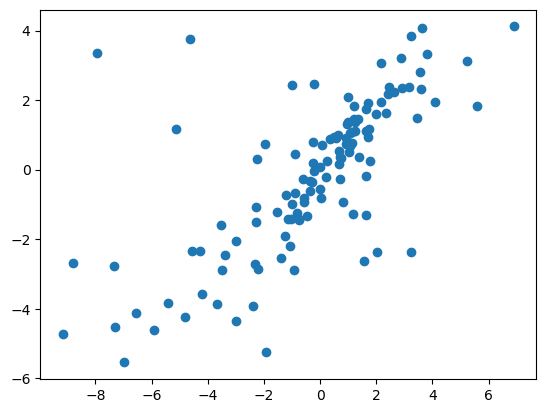

In [42]:
plt.scatter(Y2_test, pred2)

In [43]:
oos_r2_2 = 1 - mse2*5/Y2_test.var() 
print("Out of Sample R-Sqaured:", oos_r2_2)

Out of Sample R-Sqaured: -1.6021688490837507
